In [4]:
import datetime
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web

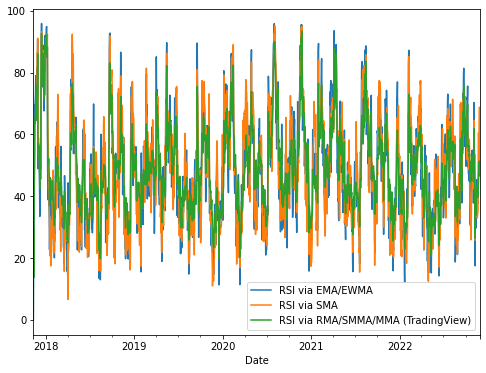

In [7]:
# Window length for moving average
length = 14

# Dates
start, end = '2013-12-14', '2022-11-27'

# Get data
data = web.DataReader('XRP-USD', 'yahoo', start, end)
# Get just the adjusted close
close = data['Adj Close']

# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

# Calculate RSI using MA of choice
# Reminder: Provide ≥ `1 + length` extra data points!
rsi_ema = calc_rsi(close, lambda s: s.ewm(span=length).mean())
rsi_sma = calc_rsi(close, lambda s: s.rolling(length).mean())
rsi_rma = calc_rsi(close, lambda s: s.ewm(alpha=1 / length).mean())  # Approximates TradingView.

# Compare graphically
plt.figure(figsize=(8, 6))
rsi_ema.plot(), rsi_sma.plot(), rsi_rma.plot()
plt.legend(['RSI via EMA/EWMA', 'RSI via SMA', 'RSI via RMA/SMMA/MMA (TradingView)'])
plt.show()